In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
from TME1 import GrowingSpheres, plot_boundaries, plot_obs_and_enemy


Charles Vin & Aymeric Delefosse <span style="float:right">DAC</span>

# XAI - TME 1 : Explication par génération d'exemples contre-factuels


## Visualisation de la couche sphérique


In [2]:
X, y = make_moons(n_samples=200, shuffle=True, noise=0.05, random_state=0)
X = (X.copy() - X.mean(axis=0)) / X.std(axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = SVC(gamma=1, probability=True)
clf = clf.fit(X_train, y_train)
print(" ### Accuracy:", accuracy_score(y_test, clf.predict(X_test)))


 ### Accuracy: 1.0


Text(0.5, 1.0, 'Spherical Layer')

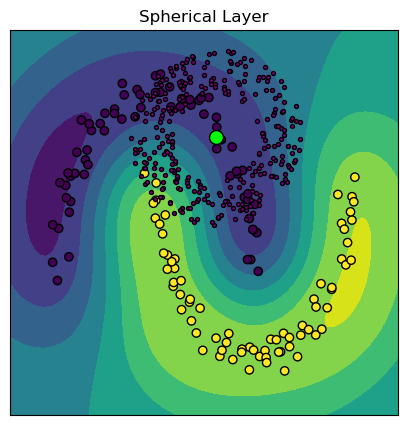

In [8]:
idx = np.random.randint(X_test.shape[0])
obs = X_test[idx, :].reshape(1, -1)

radius = 0.5
step = 0.5
N = 300

GS = GrowingSpheres(clf, 2, N)
GS.predict(obs)
SL = GS.generate_spherical_layer(radius, radius + step)

fig, ax = plt.subplots(figsize=(5, 5))
plot_boundaries(X_train, y_train, ax, clf)
ax.scatter(obs[:, 0], obs[:, 1], marker="o", color="lime", edgecolors="k", s=100)
ax.scatter(SL[:, 0], SL[:, 1], marker="o", color="purple", edgecolors="k", s=8)
ax.set_title("Spherical Layer")

On peut vérifier qu'il y a bel et bien des ennemies dans notre couche sphérique :

In [6]:
GS.find_enemy(SL)

True

Et aussi avoir leur nombre :

In [11]:
print(f"## Number of ennemies: {len(GS.enemies)} ({len(GS.enemies) / N:.2f}%)")

## Number of ennemies: 57 (0.19%)


## Expérimentations

### Stabilité

Pour mesurer la variabilité due à la composante aléatoire de l'algorithme, on générera des exemples contrefactueles multiples pour la même observation d'entrée. On pourra également comparer la stabilité de l'algorithme en utilisant différents classifieurs.


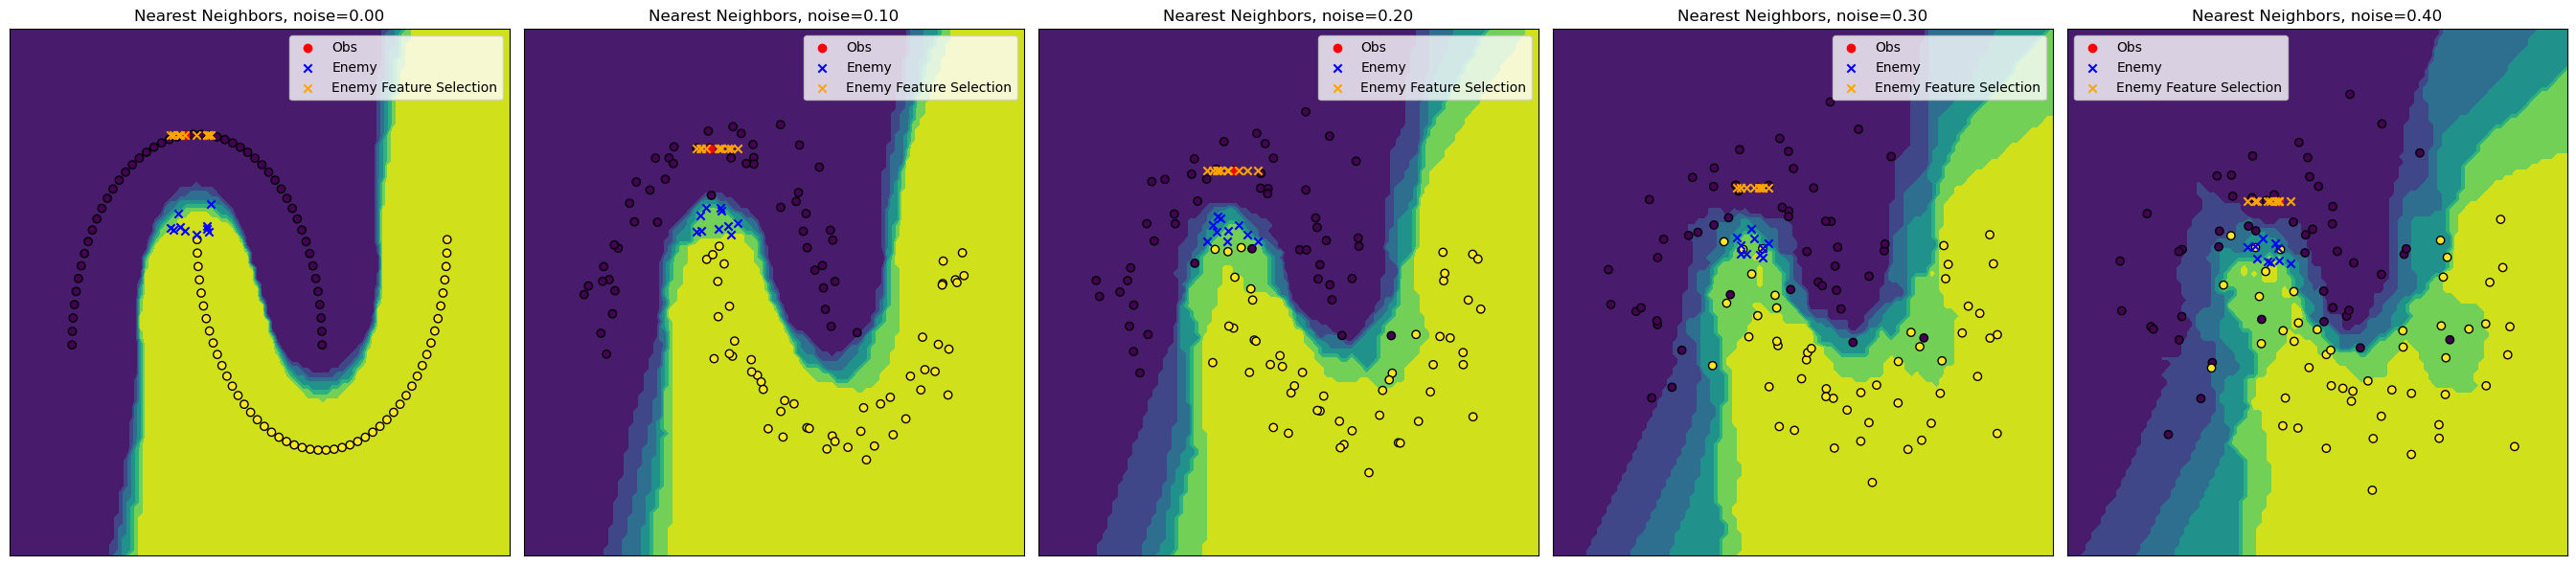

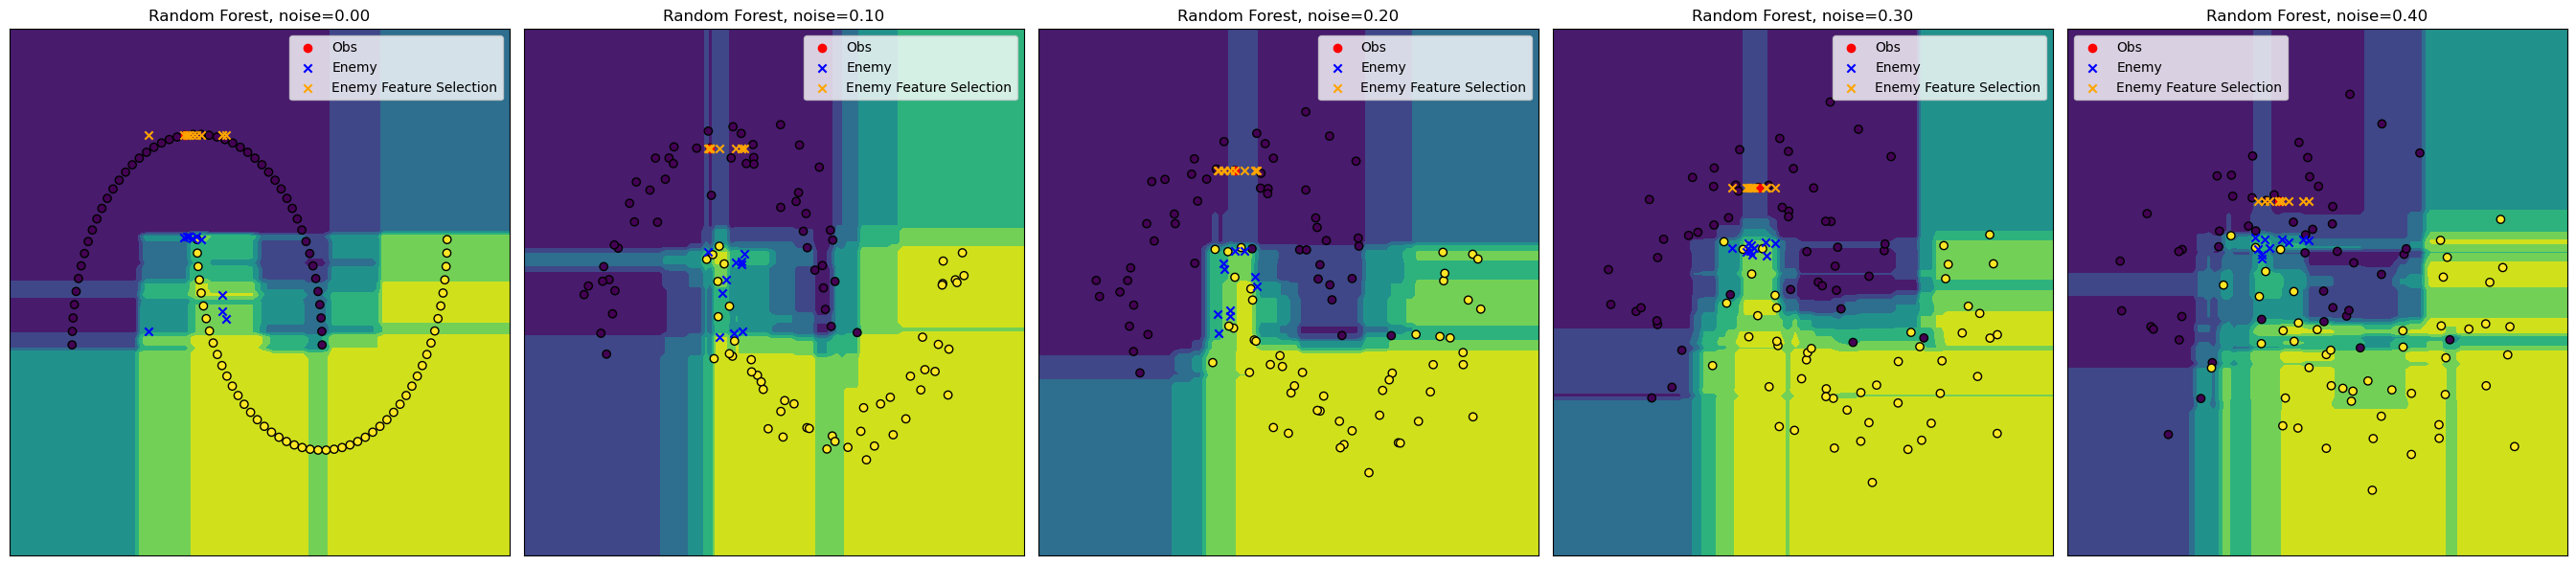

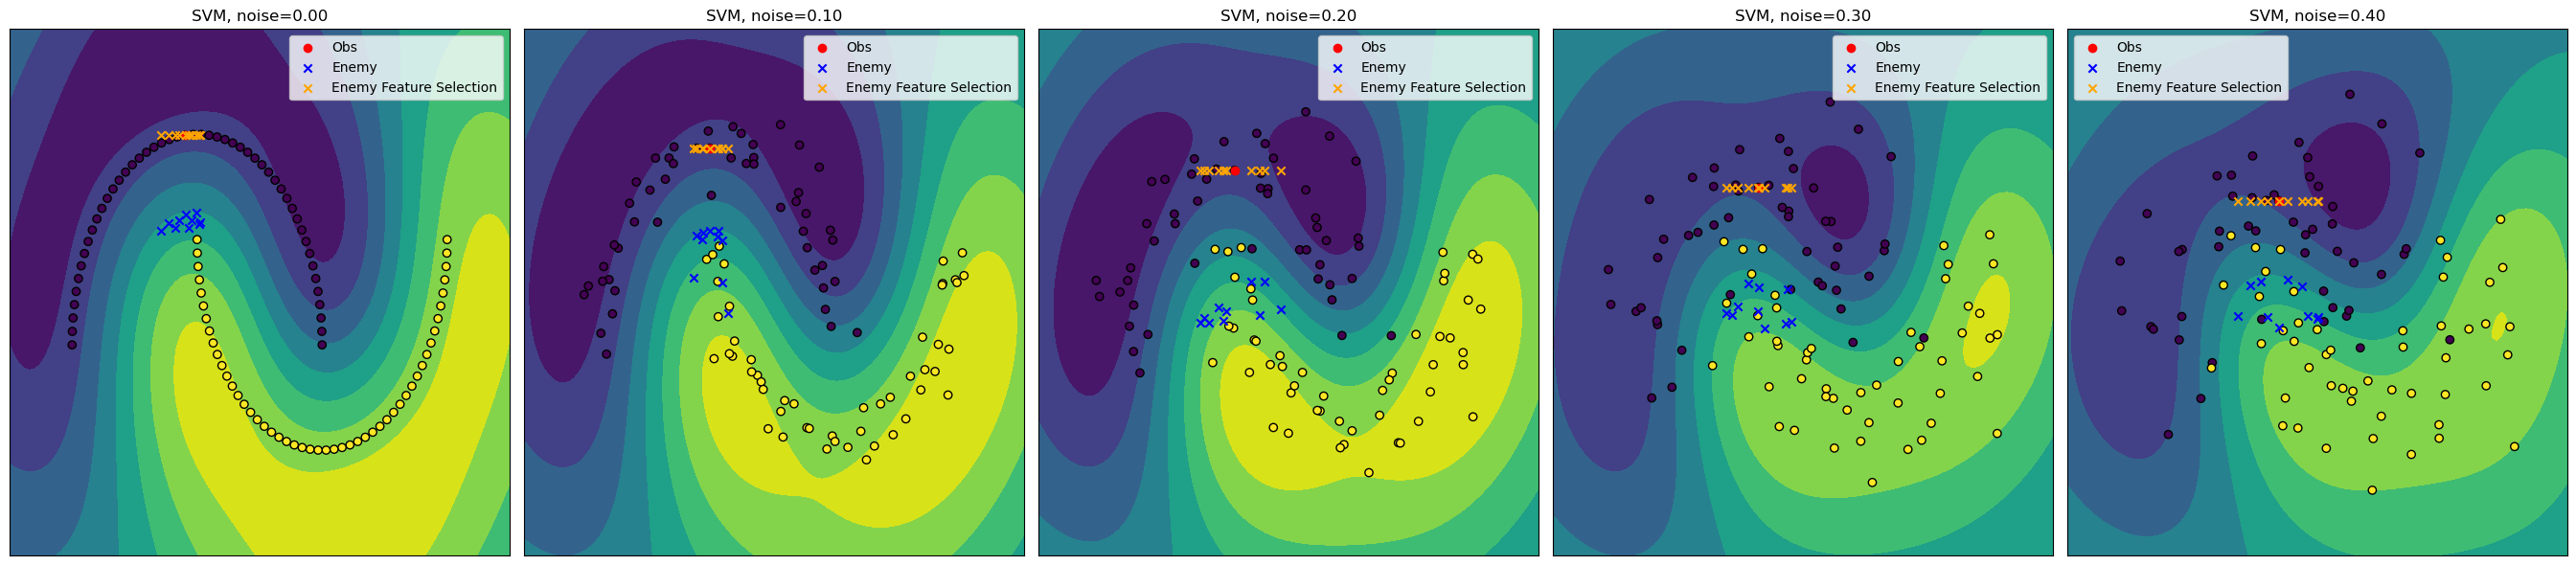

In [18]:
def oui(dataset, clf, n=10, eta=2, n_gs=100, ax=None):
    X, y = dataset
    obs_to_interprete = X[0]
    clf.fit(X, y)

    enemy_list = []
    enemy_fs_list = []
    for _ in range(n):
        gs = GrowingSpheres(clf, eta, n_gs)
        enemy, enemy_fs = gs.predict(obs_to_interprete)
        enemy_list.append(enemy)
        enemy_fs_list.append(enemy_fs)

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    ax.scatter(*obs_to_interprete, c="red", marker="o", label="Obs")

    for enemy, enemy_fs in zip(enemy_list[:-1], enemy_fs_list[:-1]):
        ax.scatter(*enemy, c="blue", marker="x")
        ax.scatter(*enemy_fs, c="orange", marker="x")
    ax.scatter(*enemy_list[-1], c="blue", marker="x", label="Enemy")
    ax.scatter(
        *enemy_fs_list[-1], c="orange", marker="x", label="Enemy Feature Selection"
    )
    ax.legend()
    return ax


names = [
    "Nearest Neighbors",
    "Random Forest",
    "SVM",
]
classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    SVC(),
]

## Création de jeux de données avec différents niveaux de bruit
datasets = []
noise_lvl = []
for noise in np.arange(0, 0.5, 0.1):
    noise_lvl.append(noise)
    datasets.append(make_moons(noise=noise, random_state=0))

for clf, name in zip(classifiers, names):
    fig = plt.figure(figsize=(27, 6))
    for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
        tmp_ax = fig.add_subplot(1, len(datasets), i + 1)
        tmp_ax.set_title(f"{name}, noise={noise:.2f}")
        oui(dataset, clf, ax=tmp_ax)
    fig.tight_layout()


**À interpréter**


### Autre dataset jouet


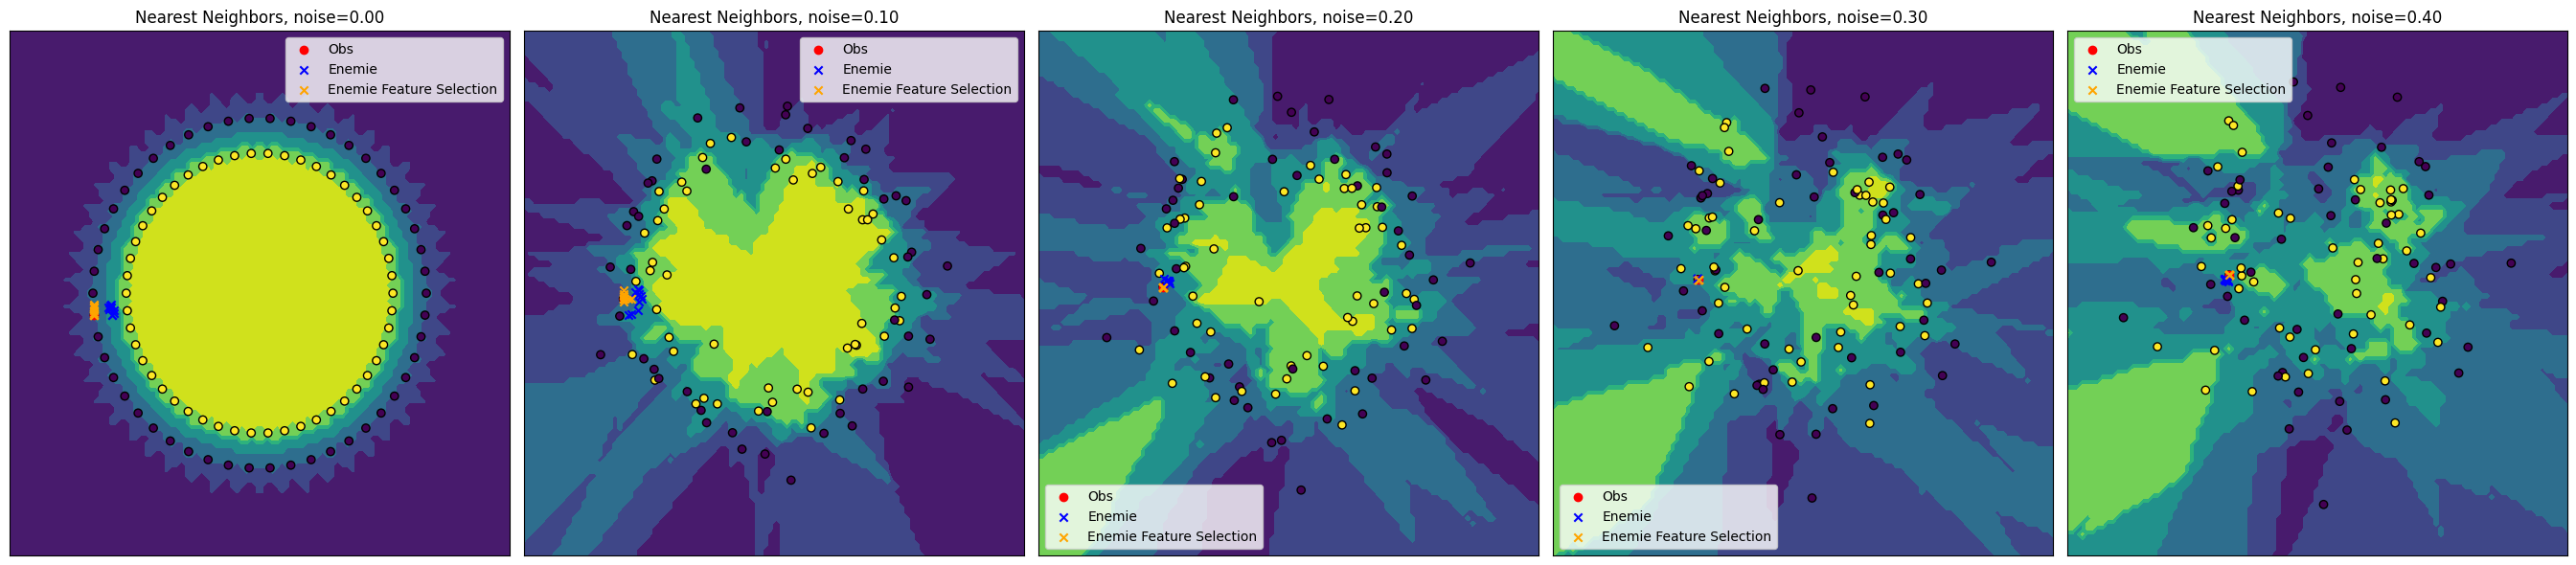

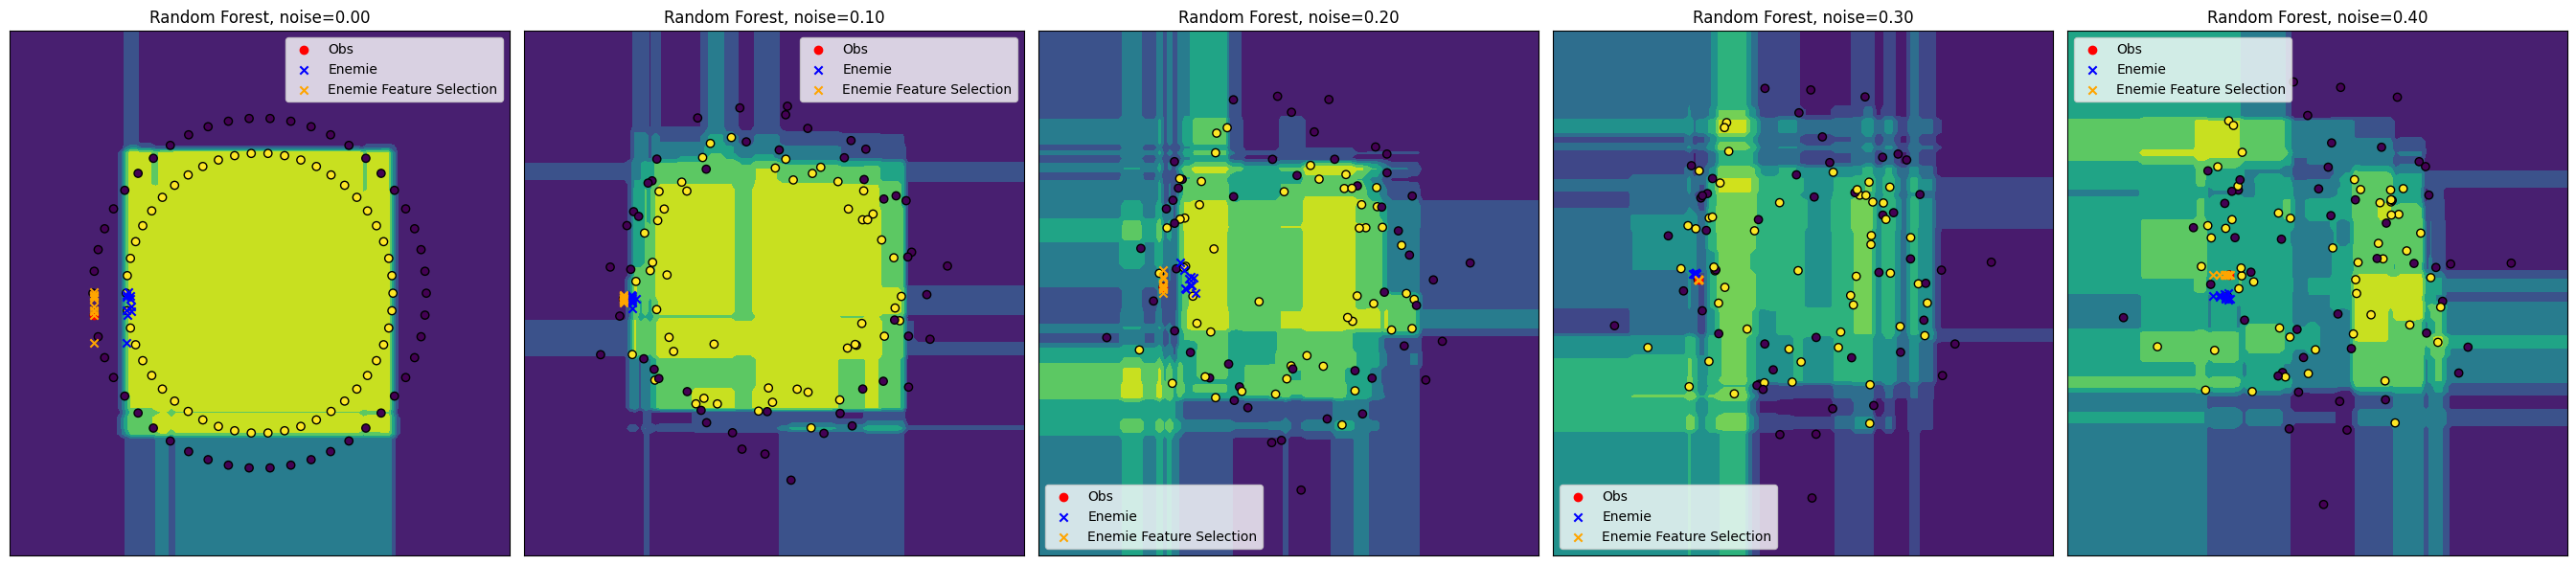

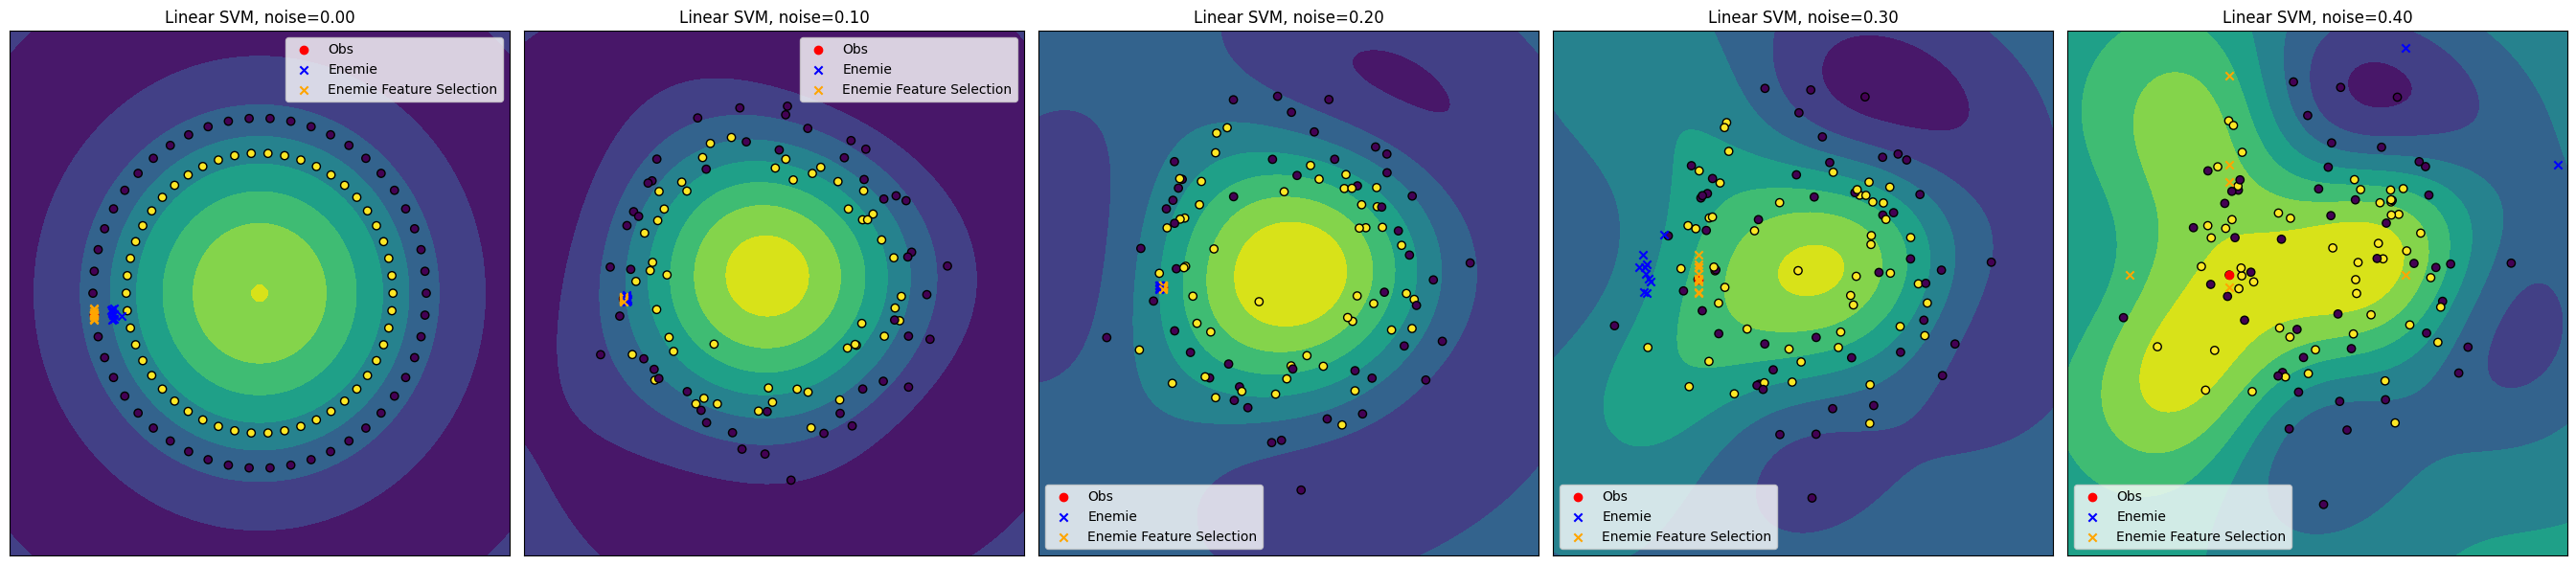

In [3]:
from sklearn.datasets import make_circles

datasets = []
noise_lvl = []
for noise in np.arange(0, 0.5, 0.1):
    noise_lvl.append(noise)
    datasets.append(make_circles(noise=noise, random_state=0))
for clf, name in zip(classifiers, names):
    fig = plt.figure(figsize=(27, 6))
    for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
        tmp_ax = fig.add_subplot(1, len(datasets), i + 1)
        tmp_ax.set_title(f"{name}, noise={noise:.2f}")
        oui(dataset, clf, ax=tmp_ax)
    fig.tight_layout()


**Maybe utiliser un autre dataset jouet parce que lui debase les clf l'aimes pas mdr**


### Données classiques


Durant le cours, nous avons particulièrement utilisé l'exemple de l'élégibilité aux prêt bancaire. Nous proposons alors d'utiliser cette exemple pour tester Growing Sphere sur des données réelles. Voici [le dataset](https://www.kaggle.com/datasets/burak3ergun/loan-data-set)

The format of the data:

- Variable Description
- Loan_ID Unique Loan ID
- Gender Male/ Female
- Married Applicant married (Y/N)
- Dependents Number of dependents
- Education Applicant Education (Graduate/ Under Graduate)
- Self_Employed Self employed (Y/N)
- ApplicantIncome Applicant income
- CoapplicantIncome Coapplicant income
- LoanAmount Loan amount in thousands
- Loan_Amount_Term Term of loan in months
- Credit_History Credit history meets guidelines
- Property_Area Urban/ Semi Urban/ Rural
- Loan_Status Loan approved (Y/N)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# df = pd.read_csv('loan_data_set.csv').drop(columns=['Loan_ID']).dropna()
df = pd.read_csv("loan_data_set.csv").drop(columns=["Loan_ID"])
df["Gender"].fillna(df["Gender"].mode()[0], inplace=True)
df["Married"].fillna(df["Married"].mode()[0], inplace=True)
df["Dependents"].fillna(df["Dependents"].mode()[0], inplace=True)
df["Self_Employed"].fillna(df["Self_Employed"].mode()[0], inplace=True)
df["Credit_History"].fillna(df["Credit_History"].mode()[0], inplace=True)
df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].mode()[0], inplace=True)
df["LoanAmount"].fillna(df["LoanAmount"].mean(), inplace=True)

df = pd.get_dummies(df).drop(
    [
        "Gender_Female",
        "Married_No",
        "Education_Not Graduate",
        "Self_Employed_No",
        "Loan_Status_N",
    ],
    axis=1,
)
new = {
    "Gender_Male": "Gender",
    "Married_Yes": "Married",
    "Education_Graduate": "Education",
    "Self_Employed_Yes": "Self_Employed",
    "Loan_Status_Y": "Loan_Status",
}
df.rename(columns=new, inplace=True)

# Q1 = df.quantile(0.25, numeric_only=True)
# Q3 = df.quantile(0.75, numeric_only=True)
# IQR = Q3 - Q1
# df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

df.ApplicantIncome = np.sqrt(df.ApplicantIncome)
df.CoapplicantIncome = np.sqrt(df.CoapplicantIncome)
df.LoanAmount = np.sqrt(df.LoanAmount)

X = df.drop(["Loan_Status"], axis=1)
y = df["Loan_Status"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
mmt = MinMaxScaler()
X_train = mmt.fit_transform(X_train)
X_test = mmt.transform(X_test)


In [5]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

clf = RandomForestClassifier(n_estimators=1000, random_state=1, max_leaf_nodes=18)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
no = y_train == 0
no_test = y_test == 0
accuracy_score(y_test, y_pred), accuracy_score(
    y_train, clf.predict(X_train)
), accuracy_score(y_train[no], clf.predict(X_train[no])), accuracy_score(
    y_test[no_test], clf.predict(X_test[no_test])
)


(0.7967479674796748,
 0.8765060240963856,
 0.7710843373493976,
 0.42424242424242425)

Beaucoup de test et impossible de faire une bonne prédiction


---


In [6]:
idx = 1
obs_to_interprete = X_train[idx]
y_train[idx], obs_to_interprete


(False,
 array([0.34446841, 0.        , 0.46893291, 0.72972973, 1.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        ]))

In [7]:
gs = GrowingSpheres(clf, 2, 100)
enemy, enemy_fs = gs.predict(obs_to_interprete)
print(clf.predict(obs_to_interprete.reshape(1, -1)))
print(clf.predict(enemy.reshape(1, -1)))
print(clf.predict(enemy_fs.reshape(1, -1)))
enemy = pd.Series(enemy, index=X.columns, name="enemy")
enemy_fs = pd.Series(enemy_fs, index=X.columns, name="enemy_fs")
pd.DataFrame([obs_to_interprete, enemy_fs, enemy], columns=X.columns)


[ True]
[False]
[ True]


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education,Self_Employed,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0.344468,0.000000,0.468933,0.729730,1.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
1,0.343013,0.000997,0.468933,0.729730,1.000000,0.999806,0.003008,0.002152,1.000000,0.00436,0.003484,1.002841,-0.001358,-0.003845,1.002994,0.000125
2,0.343013,0.000997,0.474639,0.723129,0.994457,0.999806,0.003008,0.002152,1.006857,0.00436,0.003484,1.002841,-0.001358,-0.003845,1.002994,0.000125


---


In [77]:
df_train = pd.read_csv("train.csv").dropna()
df_test = pd.read_csv("test.csv").dropna()

# Define our features and target (this is helpful in case you would like to drop any features that harm model performance)
features = [
    # "Gender",
    # "Customer Type",
    "Age",
    # "Type of Travel",
    # "Class",
    "Flight Distance",
    "Inflight wifi service",
    "Departure/Arrival time convenient",
    "Ease of Online booking",
    "Gate location",
    "Food and drink",
    "Online boarding",
    "Seat comfort",
    "Inflight entertainment",
    "On-board service",
    "Leg room service",
    "Baggage handling",
    "Checkin service",
    "Inflight service",
    "Cleanliness",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
]
target = ["satisfaction"]

# Split into test and train
oh = OneHotEncoder(handle_unknown="ignore")
# X_train = oh.fit_transform(df_train[features])
# X_test = oh.transform(df_test[features])
X_train = df_train[features]
X_test = df_test[features]
y_train = df_train[target].replace({"satisfied": 1, "neutral or dissatisfied": 0})
y_test = df_test[target].replace({"satisfied": 1, "neutral or dissatisfied": 0})

# Normalize Features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


/home/charles/M2-DAC/.venv/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ROC_AUC = 0.9463543130330968
              precision    recall  f1-score   support

           0    0.94315   0.96724   0.95504     14528
           1    0.95670   0.92547   0.94083     11365

    accuracy                        0.94891     25893
   macro avg    0.94993   0.94635   0.94794     25893
weighted avg    0.94910   0.94891   0.94880     25893



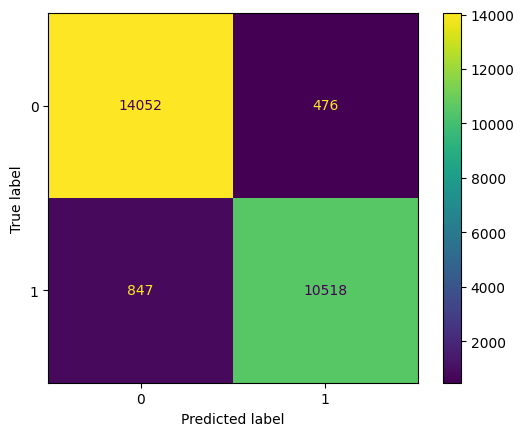

In [78]:
params_rf = {
    "max_depth": 25,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "n_estimators": 100,
    "random_state": 42,
    "n_jobs": -1,
}


def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test, y_pred, digits=5))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    return model, roc_auc


clf = RandomForestClassifier(**params_rf)
clf, roc_auc_rf = run_model(clf, X_train, y_train, X_test, y_test)


Voilà un estimateur qui fonctionne !


In [89]:
idx = 1
obs_to_interprete = X_train.loc[idx].to_numpy()
df_train.loc[idx, features], df_train.loc[idx, target]


(Age                                   25
 Flight Distance                      235
 Inflight wifi service                  3
 Departure/Arrival time convenient      2
 Ease of Online booking                 3
 Gate location                          3
 Food and drink                         1
 Online boarding                        3
 Seat comfort                           1
 Inflight entertainment                 1
 On-board service                       1
 Leg room service                       5
 Baggage handling                       3
 Checkin service                        1
 Inflight service                       4
 Cleanliness                            1
 Departure Delay in Minutes             1
 Arrival Delay in Minutes             6.0
 Name: 1, dtype: object,
 satisfaction    neutral or dissatisfied
 Name: 1, dtype: object)

In [93]:
gs = GrowingSpheres(clf, 2, 100)
enemy, enemy_fs = gs.predict(obs_to_interprete)
print("obs_to_interprete", clf.predict(obs_to_interprete.reshape(1, -1)))
print("enemy", clf.predict(enemy.reshape(1, -1)))
print("enemy_fs", clf.predict(enemy_fs.reshape(1, -1)))
enemy = pd.Series(enemy, index=X_train.columns, name="enemy")
enemy_fs = pd.Series(enemy_fs, index=X_train.columns, name="enemy_fs")
difference = pd.Series(X_train.loc[idx] - enemy_fs, name="obs - enemy_fs")
pd.DataFrame([X_train.loc[idx], enemy_fs, enemy, difference], columns=X_train.columns)


/home/charles/M2-DAC/.venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


obs_to_interprete [0]
enemy [1]
enemy_fs [0]


/home/charles/M2-DAC/.venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
1,25.000000,235.000000,3.000000,2.000000,3.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,5.00000,3.000000,1.000000,4.000000,1.000000,1.000000,6.000000
enemy_fs,25.278398,235.000000,3.000000,1.544127,2.965115,1.745768,0.055588,3.448226,1.000000,2.327065,0.591156,5.78999,1.965731,1.775557,3.773055,0.928451,0.963192,6.580616
enemy,25.278398,236.580846,4.508168,1.544127,2.965115,1.745768,0.055588,3.448226,-0.621019,2.327065,0.591156,5.78999,1.965731,1.775557,3.773055,0.928451,0.963192,6.580616
obs - enemy_fs,-0.278398,0.000000,0.000000,0.455873,0.034885,1.254232,0.944412,-0.448226,0.000000,-1.327065,0.408844,-0.78999,1.034269,-0.775557,0.226945,0.071549,0.036808,-0.580616
